In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [102]:
# Load CSV
stocks = pd.read_csv("C:/Users/DELL/Documents/favoured/datasets/Nigeria Finanical Market Data/NGX Stocks 2000 - 2025.csv")

# Preprocess data
# Filter for ZENITHBANK and select Date and Price (closing price)
stocks = stocks[stocks['Symbol'] == 'ZENITHBANK'][['Date', 'Price']].copy()
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.sort_values('Date', inplace=True)
stocks.set_index('Date', inplace=True)
stocks.rename(columns={'Price': 'Close'}, inplace=True)

# Handle missing values (if any)
stocks = stocks.dropna()

In [103]:
# Print data summary
print("Data Summary:", stocks.describe())

Data Summary:              Close
count  3294.000000
mean     23.090495
std       7.993831
min       9.000000
25%      17.502500
50%      21.825000
75%      25.100000
max      52.000000


In [104]:
#Create lagged features for ML models (5 lags)
def create_lagged_features(data, lags=5):
    df = pd.DataFrame(data, columns=['Close'])
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['Close'].shift(i)
    df['Target'] = df['Close'].shift(-1)
    return df.dropna()

lags = 5
ml_data = create_lagged_features(stocks['Close'], lags)
print(ml_data)

            Close  lag_1  lag_2  lag_3  lag_4  lag_5  Target
Date                                                        
2012-01-30  12.01  12.10  12.02  12.00  11.96  12.00   12.45
2012-01-31  12.45  12.01  12.10  12.02  12.00  11.96   12.01
2012-02-01  12.01  12.45  12.01  12.10  12.02  12.00   12.17
2012-02-02  12.17  12.01  12.45  12.01  12.10  12.02   12.40
2012-02-03  12.40  12.17  12.01  12.45  12.01  12.10   12.40
...           ...    ...    ...    ...    ...    ...     ...
2025-05-09  48.90  49.00  49.00  48.00  46.95  47.50   48.80
2025-05-12  48.80  48.90  49.00  49.00  48.00  46.95   48.00
2025-05-13  48.00  48.80  48.90  49.00  49.00  48.00   48.50
2025-05-14  48.50  48.00  48.80  48.90  49.00  49.00   48.50
2025-05-15  48.50  48.50  48.00  48.80  48.90  49.00   48.00

[3288 rows x 7 columns]


In [105]:
# Prepare data for CNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stocks['Close'].values.reshape(-1, 1))

In [106]:
# Split data (80% train, 20% test)
train_size = int(len(stocks) * 0.8)
train, test = stocks.iloc[:train_size], stocks.iloc[train_size:]
ml_train, ml_test = ml_data.iloc[:int(len(ml_data) * 0.8)], ml_data.iloc[int(len(ml_data) * 0.8):]

train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]
X_train_cnn, y_train_cnn = create_sequences(train_scaled, seq_length)
X_test_cnn, y_test_cnn = create_sequences(test_scaled, seq_length)

# Reshape for CNN [samples, timesteps, features]
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

In [107]:
# Prepare features and target for LR and RF
X_train_ml = ml_train[[f'lag_{i}' for i in range(1, lags + 1)]]
y_train_ml = ml_train['Target']
X_test_ml = ml_test[[f'lag_{i}' for i in range(1, lags + 1)]]
y_test_ml = ml_test['Target']

In [108]:
# Check for stationarity (for ARIMA)
adf_test = adfuller(stocks['Close'])
print(f'ADF p-value: {adf_test[1]}')  # Non-stationary if p > 0.05

ADF p-value: 0.7583266597828745


In [109]:
# ARIMA Model
arima_model = ARIMA(train['Close'], order=(5,1,0))  # (p,d,q) after ADF test
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test['Close'], arima_forecast)
print(f'ARIMA MSE: {arima_mse}')

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA MSE: 305.86892599675303


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [110]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_ml, y_train_ml)
lr_predictions = lr_model.predict(X_test_ml)
lr_mse = mean_squared_error(y_test_ml, lr_predictions)
print(f'Linear Regression MSE: {lr_mse}')

Linear Regression MSE: 1.5521946042394552


In [111]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
rf_predictions = rf_model.predict(X_test_ml)
rf_mse = mean_squared_error(y_test_ml, rf_predictions)
print(f'Random Forest MSE: {rf_mse}')

Random Forest MSE: 54.05702923801281


In [112]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=200, batch_size=32, verbose=0)

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_predictions = scaler.inverse_transform(cnn_predictions)
y_test_cnn_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [114]:
cnn_mse = mean_squared_error(y_test_cnn_inv, cnn_predictions)
print(f'CNN MSE: {cnn_mse}')

CNN MSE: 0.9318137206367165


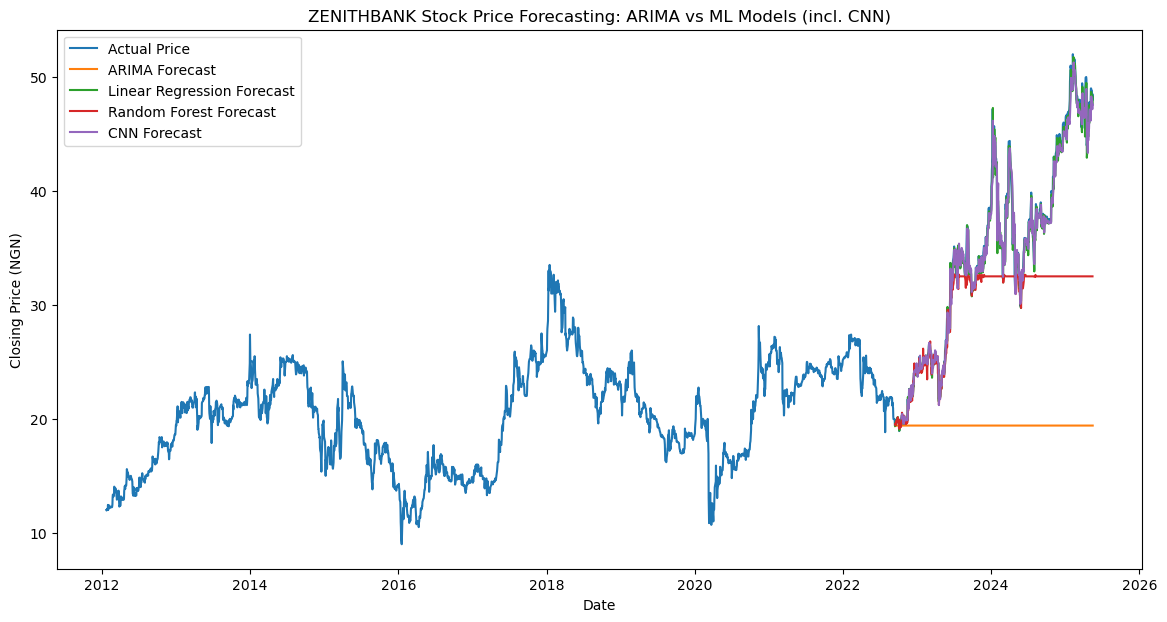

In [115]:
# Visualize results
plt.figure(figsize=(14, 7))
plt.plot(stocks.index, stocks['Close'], label='Actual Price')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(ml_test.index, lr_predictions, label='Linear Regression Forecast')
plt.plot(ml_test.index, rf_predictions, label='Random Forest Forecast')
plt.plot(test.index[seq_length:], cnn_predictions, label='CNN Forecast')
plt.title('ZENITHBANK Stock Price Forecasting: ARIMA vs ML Models (incl. CNN)')
plt.xlabel('Date')
plt.ylabel('Closing Price (NGN)')
plt.legend()
plt.show()

In [116]:
# Compare models
print(f'\nComparison for Short-Term Forecasting:')
print(f'ARIMA MSE: {arima_mse:.4f}')
print(f'Linear Regression MSE: {lr_mse:.4f}')
print(f'Random Forest MSE: {rf_mse:.4f}')
print(f'CNN MSE: {cnn_mse:.4f}')
print('Conclusion: The model with the lowest MSE performs best for short-term forecasting.')


Comparison for Short-Term Forecasting:
ARIMA MSE: 305.8689
Linear Regression MSE: 1.5522
Random Forest MSE: 54.0570
CNN MSE: 0.9318
Conclusion: The model with the lowest MSE performs best for short-term forecasting.
